# TESIS 
## Digital Pathology: Tubule Formations Analisys

Notebook: adapted from: 

- Author: Fran Pérez 
- **Pontificia Universidad Católica del Péru**

### Importing Libraris

pip install -U segmentation-models

pip install -U --pre segmentation-models

pip install git+https://github.com/qubvel/segmentation_models

In [1]:
import os
import numpy as np
import cv2
from glob import glob
import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPool2D,AveragePooling2D
from tensorflow.keras.layers import  GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2,VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.1


In [3]:
np.random.seed(38)
tf.random.set_seed(38)

### Hyperparameters

In [4]:
IMAGE_SIZE = 512
EPOCHS = 30
BATCH = 8
LR = 1e-4

PATH = "new_data/train/"

## Dataset

The dataset has been collected from BracaHad
- link: https://bmcresnotes.biomedcentral.com/articles/10.1186/s13104-019-4121-7

The data has been splitted into (80:10:10) ratio. Training, Validation and testing respectively. 

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "process/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    #test_size = int(split * total_size)
    
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)#, (test_x, test_y)

Reading the images and masks

In [6]:
def read_image(path):
    path = path.decode()
    #print(path)
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    #print('path mask: ', path)
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

Building the pipeline

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
#(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)
(train_x, train_y), (valid_x, valid_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
#print("Testing data: ", len(test_x))

Training data:  1145
Validation data:  127


In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

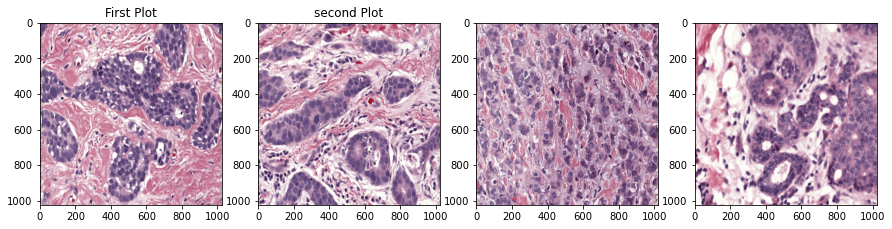

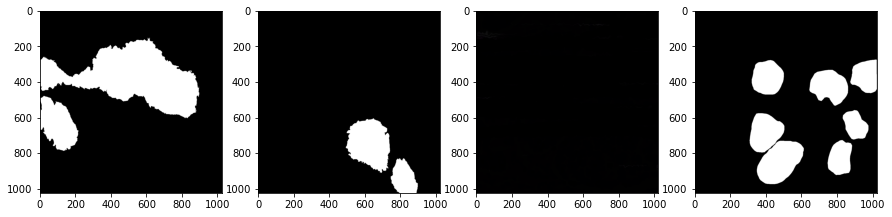

In [10]:
fig = plt.figure(figsize=(15, 15))
#fig.suptitle('This is a somewhat long figure title', fontsize=16)
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))
a.title.set_text('First Plot')
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)
a.title.set_text('second Plot')
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 1.4)
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[4]))
imgplot.set_clim(0.0, 1.4)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[4]))
imgplot.set_clim(0.0, 1.4)


## MODEL

In [11]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [12]:
model = model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

## Metrics
- Dice coef
- Accuracy

In [68]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [15]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [16]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4), ## after no improvement of val loss in 4 val=val*0.1
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False) #Stops after no improvemente of val_loss (10 times)
]

In [17]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1
history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks= callbacks,
 )


Epoch 1/50
144/144 [==============================] - 320s 2s/step - loss: 0.6973 - dice_coef: 0.3009 - recall: 0.4910 - precision: 0.3482 - val_loss: 0.7045 - val_dice_coef: 0.2961 - val_recall: 0.4307 - val_precision: 0.3951
Epoch 2/50
144/144 [==============================] - 316s 2s/step - loss: 0.6031 - dice_coef: 0.3945 - recall: 0.4099 - precision: 0.4594 - val_loss: 0.6463 - val_dice_coef: 0.3546 - val_recall: 0.2994 - val_precision: 0.5204
Epoch 3/50
144/144 [==============================] - 314s 2s/step - loss: 0.5632 - dice_coef: 0.4341 - recall: 0.3934 - precision: 0.5120 - val_loss: 0.6453 - val_dice_coef: 0.3556 - val_recall: 0.2492 - val_precision: 0.6090
Epoch 4/50
144/144 [==============================] - 316s 2s/step - loss: 0.5273 - dice_coef: 0.4698 - recall: 0.3803 - precision: 0.5618 - val_loss: 0.6421 - val_dice_coef: 0.3589 - val_recall: 0.2050 - val_precision: 0.7080
Epoch 5/50
144/144 [==============================] - 316s 2s/step - loss: 0.4935 - dice_coe

In [18]:
print(history)

### Save the model

In [19]:
model.save('mov2_8-11.h5')

In [98]:
#history.history??


In [70]:
#model = load_model('mov_8-11.h5')
#model = load_model('mov_8-11.h5', custom_objects={'dice_loss_fixed': dice_loss()})
#model = load_model('mov_8-11.h5', compile=False)


### Show Train Plots

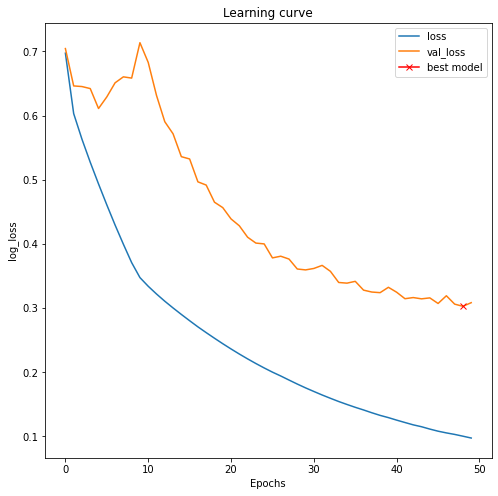

In [76]:
# Learning curve
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig('Plots/08-11-2020/LearningCurve.png', dpi=300, bbox_inches='tight')


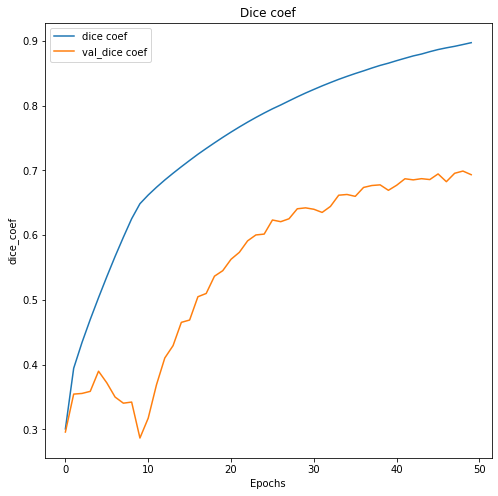

In [77]:
# Learning curve
plt.figure(figsize=(8, 8))
plt.title("Dice coef")
plt.plot(history.history["dice_coef"], label="dice coef")
plt.plot(history.history["val_dice_coef"], label="val_dice coef")
#plt.plot( np.argmin(history.history["val_dice_coef"]), np.min(history.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();
plt.savefig('Plots/08-11-2020/Dice_coef.png', dpi=300, bbox_inches='tight')


### Evaluation 

import matplotlib.pyplot as plt
filename = './new_data/test/process/26_0.tif'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (256, 256))
#feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.5), (256,256))

image2 = image
plt.imshow(unscaled)
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

#plt.imshow(out_image)

test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

### Results

In [37]:
#test path
#Tpath ="new_data/test/"

In [64]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [65]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [85]:
#for i, (x, y) in enumerate(zip(test_x[0:8], test_y[0:8])):
def show_test(path_x,path_y):
    path1 = 'new_data/test/process/' + path_x 
    path2 = 'new_data/test/mask/' + path_y
    
    x = read_image(path1)
    y = read_mask(path2)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
        ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

In [86]:
images = ['26_0.tif','26_1.tif','26_2.tif','26_3.tif','26_4.tif','26_5.tif','26_6.tif','26_7.tif','59_0.tif','59_1.tif','59_2.tif','59_3.tif','59_4.tif','59_5.tif','59_6.tif','59_7.tif','91_0.tif','91_1.tif','91_2.tif','91_3.tif','91_4.tif','91_5.tif','91_6.tif','91_7.tif','TGA.png',
]

mask = ['26_0.png','26_1.png','26_2.png','26_3.png','26_4.png','26_5.png','26_6.png','26_7.png','59_0.png','59_1.png','59_2.png','59_3.png','59_4.png','59_5.png','59_6.png','59_7.png','91_0.png','91_1.png','91_2.png','91_3.png','91_4.png','91_5.png','91_6.png','91_7.png','TGA.png','91_6.tif.png','91_7.tif.png','TGA.png.png',
]

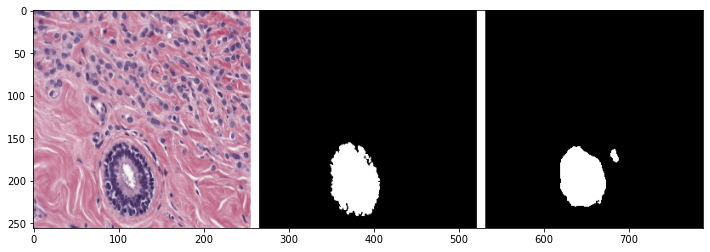

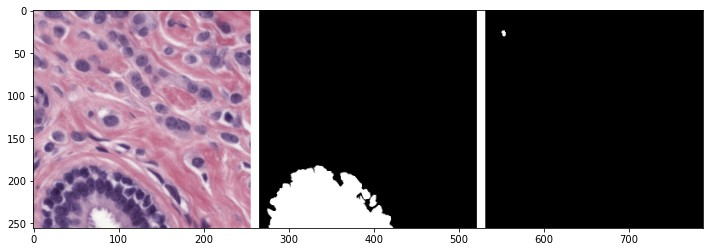

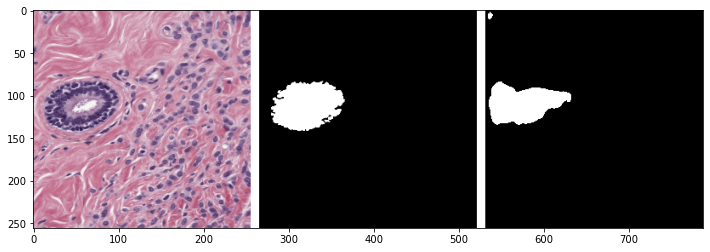

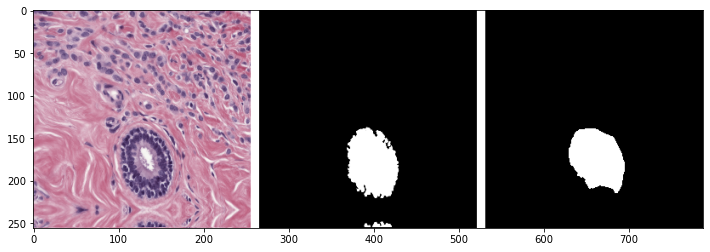

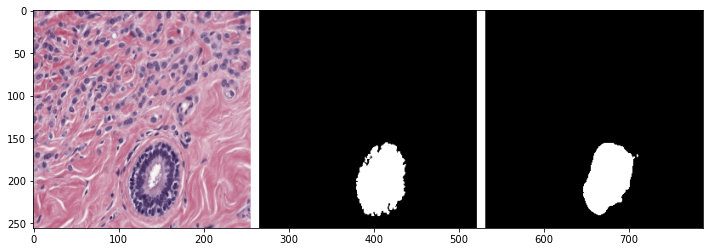

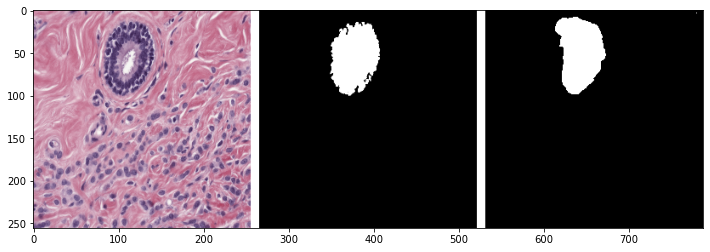

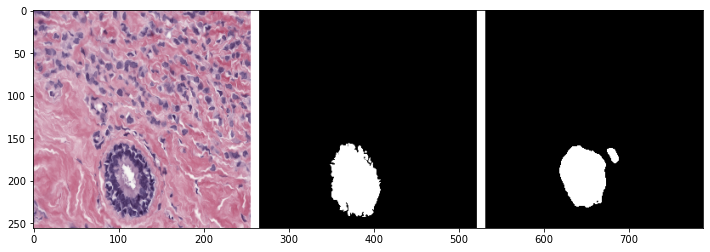

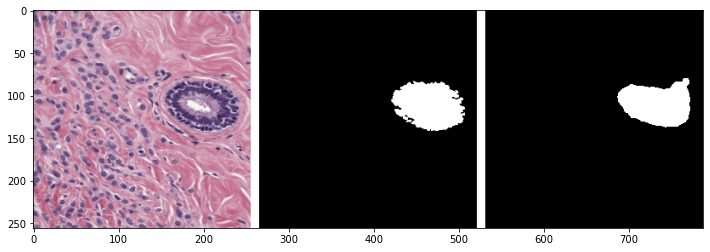

In [97]:
for i in range(0,8,1):
    show_test(images[i],mask[i])
    